In [1]:
import re
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

%matplotlib inline

In [2]:
def get_df(athlete_id: int):
    athlete_url = f'https://www.parkrun.ru/results/athleteeventresultshistory/?athleteNumber={athlete_id}&eventNumber=0'
    page_all_results = requests.get(athlete_url, headers={'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:86.0) Gecko/20100101 Firefox/86.0'})
    df = pd.read_html(page_all_results.text)[2]
    df['Номер пробежки'] = df['Номер пробежки'].apply(int)
    df['Место'] = df['Место'].apply(int)
    df['time'] = df['Время'].transform(lambda time: sum(x * int(t) for x, t in zip([1/60, 1, 60], time.split(':')[::-1])))
    return df

In [3]:
my_id = 875743
my_df = get_df(my_id)

In [4]:
my_df['Год'] = pd.to_datetime(my_df['Дата parkrun'], dayfirst=True).dt.year
my_df['Месяц'] = pd.to_datetime(my_df['Дата parkrun'], dayfirst=True).dt.month_name(locale='ru_RU.UTF-8').str.slice(stop=3)
my_df

,Паркран,Дата parkrun,Номер пробежки,Место,Время,Рейтинг,ЛР?,time,Год,Месяц
0,Kuzminki,24/04/2021,207,21,23:09,58.10%,NaN,23.150000,2021,Апр
1,Tula Central,23/01/2021,178,2,20:00,67.25%,NaN,20.000000,2021,Янв
2,Tula Central,16/01/2021,177,1,20:11,66.64%,NaN,20.183333,2021,Янв
3,Tula Central,09/01/2021,176,2,19:52,67.70%,NaN,19.866667,2021,Янв
4,Tula Central,02/01/2021,174,1,21:39,62.12%,NaN,21.650000,2021,Янв
...,...,...,...,...,...,...,...,...,...,...
180,Gorky Park,25/10/2014,25,1,18:07,71.76%,NaN,18.116667,2014,Окт
181,Kolomenskoe,22/03/2014,4,2,19:14,67.42%,NaN,19.233333,2014,Мар
182,Kolomenskoe,15/03/2014,3,10,20:01,64.78%,NaN,20.016667,2014,Мар
183,Kolomenskoe,08/03/2014,2,2,18:59,68.31%,NaN,18.983333,2014,Мар


In [5]:
rundata_long = my_df.pivot_table(index='Месяц', columns='Год', values='Время', aggfunc=len, fill_value=0).astype(int)
months = ['Янв','Фев','Мар','Апр','Мая','Июн','Июл','Авг','Сен','Окт','Ноя','Дек']
for month in months:
    if month not in rundata_long.index.values:
        rundata_long.loc[month] = 0
# sort chronological
rundata_long = rundata_long.reindex(months)
maxruns = rundata_long.max().max()

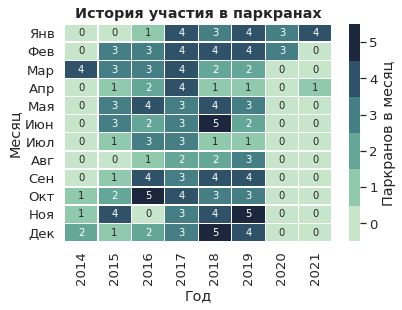

CPU times: user 3.01 s, sys: 3.44 s, total: 6.45 s
Wall time: 10.9 s


In [8]:
%%time
fig, ax = plt.subplots(figsize=(6, 4))

# Plot number of runs by month/year
cmap = sns.cubehelix_palette(rot=-.4, n_colors=maxruns+1)

ticks=np.arange(0,maxruns+1)
boundaries = np.arange(-0.5,maxruns+1.5 )

ax = sns.heatmap(rundata_long, annot=True, linewidths=0.4, cmap=cmap,
                 cbar_kws={"ticks":ticks, "boundaries":boundaries,'label': 'Паркранов в месяц'})
ax.set_title("История участия в паркранах", fontweight='bold')

plt.show()